### Inference 결과와 GT 비교
픽셀 면적을 비교하여 어떤 클래스를 모델이 추론하기 어려워 하는지 분석.
val.csv 는 fold1만 있는 것 같음

In [1]:
# 필요한 라이브러리 임포트
import os
import json
import numpy as np
import pandas as pd
import cv2

# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    """
    RLE 데이터를 디코딩하여 2D 마스크로 변환합니다.
    :param mask_rle: RLE 데이터 문자열 (공백으로 구분된 시작 위치와 길이)
    :param shape: 디코딩할 이미지의 (높이, 너비) 형태
    :return: 2D 배열 형태의 마스크
    """
    s = list(map(int, mask_rle.split()))
    starts, lengths = s[0::2], s[1::2]
    starts = np.array(starts) - 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for start, end in zip(starts, ends):
        img[start:end] = 1
    return img.reshape(shape)

# JSON 파일에서 마스크 데이터를 로드하는 함수
def load_json_mask(json_path, shape):
    """
    JSON 파일에서 마스크 데이터를 로드하고 디코딩합니다.
    :param json_path: JSON 파일 경로
    :param shape: 디코딩할 이미지의 (높이, 너비) 형태
    :return: 클래스별 디코딩된 마스크 딕셔너리
    """
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    masks = {}
    for obj in data["annotations"]:
        cls = obj["label"]  # 'label' 키 사용
        points = np.array(obj["points"])  # 폴리곤 좌표
        mask = np.zeros(shape, dtype=np.uint8)
        cv2.fillPoly(mask, [points.astype(np.int32)], 1)  # 폴리곤을 마스크로 변환
        masks[cls] = mask
    return masks

# 클래스별 면적 차이를 계산하는 함수
def calculate_area_difference(val_masks, gt_masks):
    """
    클래스별로 GT와 val 데이터의 차이가 나는 픽셀 면적을 계산합니다.
    :param val_masks: val 데이터에서 디코딩된 마스크 딕셔너리
    :param gt_masks: GT 데이터에서 디코딩된 마스크 딕셔너리
    :return: 클래스별 차이 면적 딕셔너리
    """
    area_diff = {}
    all_classes = set(val_masks.keys()).union(set(gt_masks.keys()))
    for cls in all_classes:
        val_mask = val_masks.get(cls, np.zeros_like(next(iter(gt_masks.values()))))
        gt_mask = gt_masks.get(cls, np.zeros_like(next(iter(gt_masks.values()))))
        difference = np.abs(val_mask - gt_mask)
        area_diff[cls] = np.sum(difference)
    return area_diff

# 전체 데이터셋 처리 함수
def process_all_images(val_data, gt_base_dir, start_id=1, end_id=548, shape=(2048, 2048)):
    """
    전체 이미지에 대해 val.csv와 GT를 비교하여 클래스별 면적 차이를 계산.
    :param val_data: val.csv에서 로드된 데이터프레임
    :param gt_base_dir: GT JSON 파일이 저장된 기본 디렉토리 경로
    :param start_id: 시작 ID (정수)
    :param end_id: 종료 ID (정수)
    :param shape: 이미지 마스크의 크기 (높이, 너비)
    :return: 전체 클래스별 면적 차이 결과 딕셔너리
    """
    total_differences = {}

    for image_id in range(start_id, end_id + 1):
        folder_name = f"ID{str(image_id).zfill(3)}"
        gt_dir = os.path.join(gt_base_dir, folder_name)

        # 디렉토리가 없으면 건너뛰기
        if not os.path.exists(gt_dir):
            continue
        
        # 디렉토리 내 JSON 파일들 순회
        for json_file in os.listdir(gt_dir):
            if json_file.endswith(".json"):
                image_name = json_file.replace(".json", "")

                # GT JSON 로드
                gt_json_path = os.path.join(gt_dir, json_file)
                gt_masks = load_json_mask(gt_json_path, shape)

                # val.csv에서 해당 이미지의 RLE 데이터 추출
                val_image_data = val_data[val_data["image_name"] == f"{image_name}.png"]
                if val_image_data.empty:
                    continue  # val.csv에 해당 이미지가 없으면 건너뛰기

                # val_masks 생성 부분 수정
                val_masks = {}
                for _, row in val_image_data.iterrows():
                    if pd.isna(row["rle"]):  # rle 값이 NaN인 경우
                        val_masks[row["class"]] = np.zeros(shape, dtype=np.uint8)
                    else:
                        val_masks[row["class"]] = rle_decode(row["rle"], shape)


                # 클래스별 차이 면적 계산
                area_difference = calculate_area_difference(val_masks, gt_masks)

                # 결과 합산
                for cls, diff in area_difference.items():
                    if cls not in total_differences:
                        total_differences[cls] = 0
                    total_differences[cls] += diff

    return total_differences

# CSV 데이터 로드
val_csv_path = "/data/ephemeral/home/jseo/val.csv"
val_data = pd.read_csv(val_csv_path)

# GT JSON 파일의 기본 경로
gt_base_dir = "/data/ephemeral/home/data/train/outputs_json"

# 전체 데이터셋에 대해 클래스별 면적 차이 계산
overall_differences = process_all_images(val_data, gt_base_dir, shape=(2048, 2048))

# 결과 출력
print("Overall Class-wise Area Difference:")
for cls, diff in overall_differences.items():
    print(f"Class {cls}: {diff} pixels")


Overall Class-wise Area Difference:
Class finger-13: 7932691.0 pixels
Class finger-10: 9849491.0 pixels
Class finger-4: 3156835.0 pixels
Class finger-9: 7618805.0 pixels
Class finger-7: 63336890.0 pixels
Class finger-11: 52974977.0 pixels
Class finger-6: 11203909.0 pixels
Class finger-12: 3902205.0 pixels
Class Capitate: 171756563.0 pixels
Class Ulna: 6458916.0 pixels
Class finger-18: 10493188.0 pixels
Class finger-17: 6474816.0 pixels
Class finger-3: 21968666.0 pixels
Class Trapezoid: 16404158.0 pixels
Class Trapezium: 106010821.0 pixels
Class Lunate: 12812229.0 pixels
Class Triquetrum: 149839618.0 pixels
Class finger-15: 57949412.0 pixels
Class Hamate: 27831704.0 pixels
Class finger-1: 9117696.0 pixels
Class finger-16: 5180672.0 pixels
Class finger-8: 3820072.0 pixels
Class Pisiform: 14427703.0 pixels
Class finger-14: 10074781.0 pixels
Class finger-19: 88844433.0 pixels
Class finger-5: 8497908.0 pixels
Class Scaphoid: 31801343.0 pixels
Class finger-2: 11975375.0 pixels
Class Radius: 

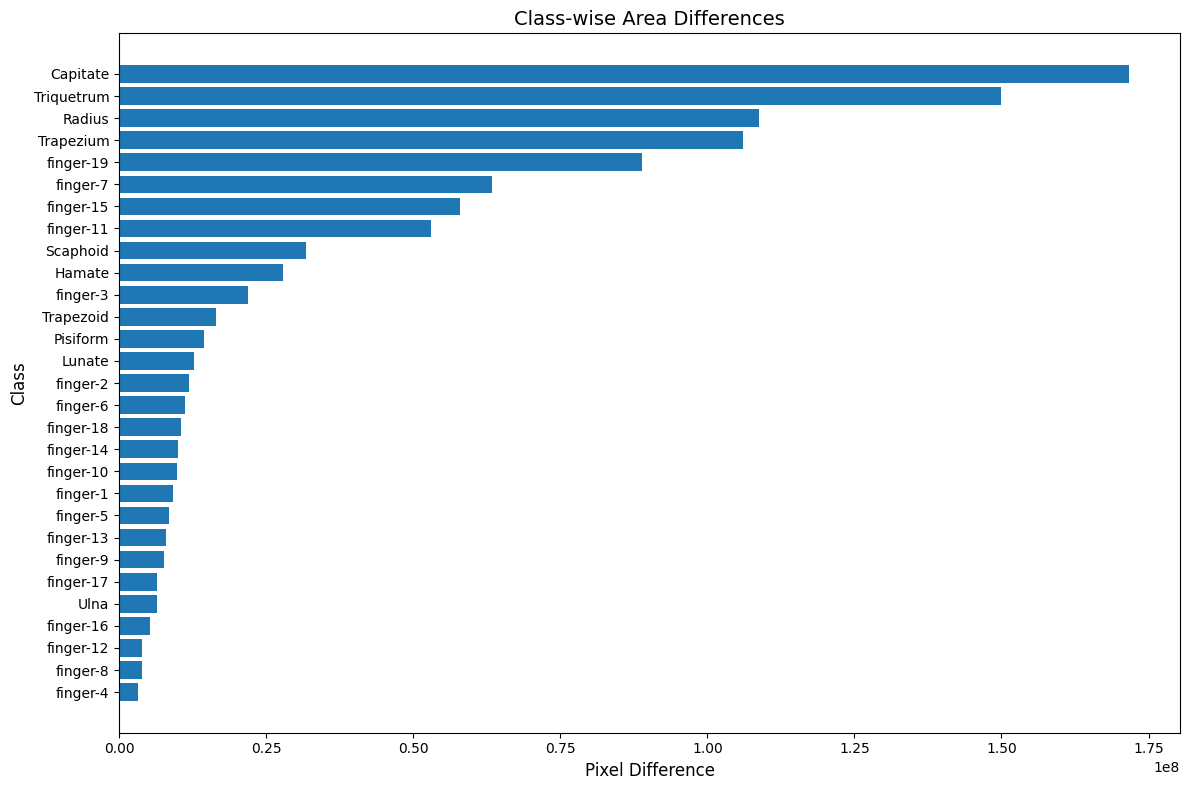

In [2]:
import matplotlib.pyplot as plt

# 데이터를 클래스별로 정렬
sorted_classes = sorted(overall_differences.items(), key=lambda x: x[1], reverse=True)

# 클래스명과 차이 면적 추출
classes, differences = zip(*sorted_classes)

# 그래프 생성
plt.figure(figsize=(12, 8))
plt.barh(classes, differences, align="center")
plt.xlabel("Pixel Difference", fontsize=12)
plt.ylabel("Class", fontsize=12)
plt.title("Class-wise Area Differences", fontsize=14)
plt.gca().invert_yaxis()  # 클래스가 위에서 아래로 보이도록 반전
plt.tight_layout()
plt.show()
